In [1]:
import cv2 
import os 
import glob
import numpy as np

import matplotlib.pyplot as plt 

from tqdm import tqdm 
from module.utils import imread
from module.disp_measure import convert_by_img

In [2]:
img_list = glob.glob(os.path.join(r'D:\UOS-SSaS Dropbox\02. Projects\2019 NIA 인공지능기반 시설물 스마트 모니터링 체계 구축\2020.08.14 변위탐지모듈 파이썬변환', 'P34_9', '*.jpg'))

In [3]:
img_list[15]

'D:\\UOS-SSaS Dropbox\\02. Projects\\2019 NIA 인공지능기반 시설물 스마트 모니터링 체계 구축\\2020.08.14 변위탐지모듈 파이썬변환\\P34_9\\Img_059_20200623_110100.jpg'

In [4]:
result = [] 
src_img = imread(img_list[0])

for num, img_path in enumerate(img_list): 
    dest_img = imread(img_path)
    result.append(convert_by_img(dest_img,
                                 src_img,
                                 min_rad = 30,
                                 max_rad = 40,
                                 param1 = 100,
                                 param2 = 15))
    print('image number', num)

x_dist 0.0 y_dist 0.0
image number 0
x_dist 2.0 y_dist 0.0
image number 1
x_dist 0.0 y_dist 2.0
image number 2
x_dist 2.0 y_dist 3.0
image number 3
x_dist 1.0 y_dist 0.0
image number 4
x_dist 1.0 y_dist 1.0
image number 5
x_dist 2.0 y_dist 1.0
image number 6
x_dist 2.0 y_dist 0.0
image number 7
x_dist 0.0 y_dist 1.0
image number 8
x_dist 1.0 y_dist 1.0
image number 9
x_dist 0.0 y_dist 0.0
image number 10
x_dist 0.0 y_dist 1.0
image number 11
x_dist 2.0 y_dist 2.0
image number 12
x_dist 1.0 y_dist 1.0
image number 13
x_dist 2.0 y_dist 3.0
image number 14
x_dist 1.0 y_dist 3.0
image number 15
x_dist 0.0 y_dist 1.0
image number 16
x_dist 314.0 y_dist 374.0
x_dist 81.0 y_dist 16.0
x_dist 81.0 y_dist 16.0
x_dist 81.0 y_dist 16.0
x_dist 1.0 y_dist 1.0
image number 17
x_dist 1.0 y_dist 0.0
image number 18
x_dist 0.0 y_dist 2.0
image number 19
x_dist 2.0 y_dist 0.0
image number 20
x_dist 0.0 y_dist 0.0
image number 21
x_dist 2.0 y_dist 2.0
image number 22
x_dist 2.0 y_dist 1.0
image number 23


x_dist 2.0 y_dist 1.0
image number 176
x_dist 0.0 y_dist 3.0
image number 177
x_dist 1.0 y_dist 0.0
image number 178
x_dist 1.0 y_dist 1.0
image number 179
x_dist 2.0 y_dist 0.0
image number 180
x_dist 3.0 y_dist 1.0
image number 181
x_dist 0.0 y_dist 0.0
image number 182
x_dist 2.0 y_dist 1.0
image number 183
x_dist 1.0 y_dist 3.0
image number 184
x_dist 0.0 y_dist 2.0
image number 185
x_dist 1.0 y_dist 3.0
image number 186
x_dist 0.0 y_dist 0.0
image number 187
x_dist 1.0 y_dist 1.0
image number 188
x_dist 0.0 y_dist 1.0
image number 189
x_dist 0.0 y_dist 1.0
image number 190
x_dist 1.0 y_dist 2.0
image number 191
x_dist 3.0 y_dist 191.0
x_dist 1.0 y_dist 0.0
image number 192
x_dist 1.0 y_dist 1.0
image number 193
x_dist 1.0 y_dist 2.0
image number 194
x_dist 4.0 y_dist 10.0
x_dist 2.0 y_dist 2.0
image number 195
x_dist 1.0 y_dist 2.0
image number 196
x_dist 1.0 y_dist 2.0
image number 197
x_dist 3.0 y_dist 1.0
image number 198
x_dist 1.0 y_dist 1.0
image number 199
x_dist 1.0 y_dist

x_dist 0.0 y_dist 1.0
image number 362
x_dist 3.0 y_dist 0.0
image number 363
x_dist 2.0 y_dist 1.0
image number 364
x_dist 1.0 y_dist 1.0
image number 365
x_dist 2.0 y_dist 1.0
image number 366
x_dist 3.0 y_dist 3.0
image number 367
x_dist 0.0 y_dist 1.0
image number 368
x_dist 0.0 y_dist 2.0
image number 369
x_dist 1.0 y_dist 2.0
image number 370
x_dist 0.0 y_dist 2.0
image number 371
x_dist 1.0 y_dist 2.0
image number 372
x_dist 2.0 y_dist 0.0
image number 373
x_dist 1.0 y_dist 1.0
image number 374
x_dist 1.0 y_dist 2.0
image number 375
x_dist 0.0 y_dist 1.0
image number 376
x_dist 3.0 y_dist 187.0
x_dist 3.0 y_dist 187.0
x_dist 23.0 y_dist 38.0
x_dist 23.0 y_dist 38.0
x_dist 31.0 y_dist 13.0
x_dist 31.0 y_dist 13.0
x_dist 1.0 y_dist 3.0
image number 377
x_dist 1.0 y_dist 1.0
image number 378
x_dist 0.0 y_dist 0.0
image number 379
x_dist 0.0 y_dist 3.0
image number 380
x_dist 2.0 y_dist 0.0
image number 381
x_dist 1.0 y_dist 2.0
image number 382
x_dist 2.0 y_dist 0.0
image number 38

image number 540
x_dist 2.0 y_dist 1.0
image number 541
x_dist 2.0 y_dist 1.0
image number 542
x_dist 3.0 y_dist 3.0
image number 543
x_dist 0.0 y_dist 1.0
image number 544
x_dist 4.0 y_dist 2.0
image number 545
x_dist 0.0 y_dist 2.0
image number 546
x_dist 1.0 y_dist 2.0
image number 547
x_dist 3.0 y_dist 1.0
image number 548
x_dist 3.0 y_dist 1.0
image number 549
x_dist 2.0 y_dist 2.0
image number 550
x_dist 1.0 y_dist 2.0
image number 551
x_dist 0.0 y_dist 2.0
image number 552
x_dist 0.0 y_dist 3.0
image number 553
x_dist 2.0 y_dist 0.0
image number 554
x_dist 0.0 y_dist 2.0
image number 555
x_dist 1.0 y_dist 1.0
image number 556
x_dist 0.0 y_dist 1.0
image number 557
x_dist 0.0 y_dist 2.0
image number 558
x_dist 0.0 y_dist 1.0
image number 559
x_dist 1.0 y_dist 2.0
image number 560
x_dist 0.0 y_dist 2.0
image number 561
x_dist 1.0 y_dist 3.0
image number 562
x_dist 1.0 y_dist 3.0
image number 563
x_dist 1.0 y_dist 1.0
image number 564
x_dist 1.0 y_dist 1.0
image number 565
x_dist 0

x_dist 1.0 y_dist 1.0
image number 725
x_dist 1.0 y_dist 2.0
image number 726
x_dist 3.0 y_dist 1.0
image number 727
x_dist 2.0 y_dist 2.0
image number 728
x_dist 2.0 y_dist 3.0
image number 729
x_dist 1.0 y_dist 1.0
image number 730
x_dist 0.0 y_dist 2.0
image number 731
x_dist 1.0 y_dist 3.0
image number 732
x_dist 1.0 y_dist 1.0
image number 733
x_dist 3.0 y_dist 0.0
image number 734
x_dist 1.0 y_dist 4.0
image number 735
x_dist 0.0 y_dist 1.0
image number 736
x_dist 0.0 y_dist 2.0
image number 737
x_dist 1.0 y_dist 1.0
image number 738
x_dist 0.0 y_dist 0.0
image number 739
x_dist 2.0 y_dist 0.0
image number 740
x_dist 1.0 y_dist 3.0
image number 741
x_dist 3.0 y_dist 0.0
image number 742
x_dist 3.0 y_dist 1.0
image number 743
x_dist 0.0 y_dist 1.0
image number 744
x_dist 0.0 y_dist 0.0
image number 745
x_dist 2.0 y_dist 1.0
image number 746
x_dist 2.0 y_dist 2.0
image number 747
x_dist 1.0 y_dist 4.0
image number 748
x_dist 0.0 y_dist 2.0
image number 749
x_dist 0.0 y_dist 0.0
ima

In [5]:
collect_rslt = []
for rslt in result : 
    collect_rslt.append(rslt[0])

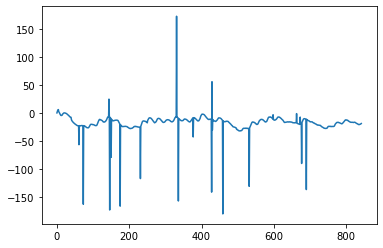

In [6]:
plt.plot(np.array(collect_rslt))

In [9]:
np.savetxt("P34_7.csv", np.array(collect_rslt), delimiter=",")

In [ ]:
## check the circle detection accuracy 

param1 = 100
param2 = 16
min_rad = 30
max_rad = 40
img = imread(img_list[670]) 
grey_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

ret3, th3 = cv2.threshold(grey_img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

circles = cv2.HoughCircles(th3, 
                               cv2.HOUGH_GRADIENT,
                               1, 
                               20, 
                               param1=param1,
                               param2=param2,
                               minRadius=min_rad,
                               maxRadius=max_rad)

# Draw circles that are detected. 
if circles is not None: 
  
    # Convert the circle parameters a, b and r to integers. 
    circles = np.uint16(np.around(circles)) 
  
    for pt in circles[0, :]: 
        a, b, r = pt[0], pt[1], pt[2] 
  
        # Draw the circumference of the circle. 
        cv2.circle(th3, (a, b), r, (0, 255, 0), 2) 
  
        # Draw a small circle (of radius 1) to show the center. 
        cv2.circle(th3, (a, b), 1, (0, 0, 255), 3) 
        cv2.imshow("Detected Circle", th3) 
        cv2.waitKey(0) 
else:
        cv2.imshow('Circle is not detected', th3)
        cv2.waitKey(0) 